# Movie Reviews Analysis Sentiment ML

## 1. Preparations

### 1.1 Library Preparations

In [10]:
pip install pandas nltk spacy beautifulsoup4 tqdm scikit-learn matplotlib wordcloud gensim fasttext-wheel seaborn

  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [seaborn]m1/2 [seaborn]
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1.2 Dataset Preparations

In [1]:
import pandas as pd

df = pd.read_csv('datasets/raw/IMDB_dataset.csv')
df.sample(10)

Bad pipe message: %s [b' 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Sa']
Bad pipe message: %s [b'ri/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/', b'ng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nA']
Bad pipe message: %s [b'ept-Language: en-US,en;q=0.9,id;q=0.8\r\nPriority: u=0, i\r\nReferer: https://idx.google.com/\r\nSec-Ch-', b': "Google Chrome";v="137", "Chromium";v="137", "Not/A)Brand";v="24"\r\nSec-Ch-Ua-Arch:', b'x86"\r\nSec-Ch-Ua-Bitness: "64"\r\n']
Bad pipe message: %s [b'c-Ch-Ua-Form-Factors: "Desktop"\r\nSec-Ch-Ua-Full-Version: "137.0.7151.104"\r\nSec-Ch-', b'-Full-Version-List: "Google Chrome";v="137.0.7151.104", "Chromium";v="137.0.7151.104', b' "Not/A)Brand";v="24.0.0.0"\r\nSec-']
Bad pipe message: %s [b'-Ua-Mobile: ?0\r\nSec-Ch-Ua-Model: ""\r\nSec-Ch-Ua-Platform: "Windows"']
Bad pipe message: %s [b'Sec-Ch-Ua-Pl']
Bad pipe message: %s 

,review,sentiment
6817,Reading all of the comments Are very exciting....,positive
7125,This is waaaaay to much.. so frustrating to wa...,negative
47015,The story concerns a genealogy researcher (Mel...,negative
43573,I totally agree with the review by a reviewer ...,negative
38956,A hint I think may be gathered by the various ...,negative
43872,Personal taste rules when it comes to talking ...,positive
23228,I thought the children in the show did a very ...,positive
11168,*** Spoiler in fifth paragraph *** This was an...,positive
25846,This movie is the final straw. As two dedicate...,negative
42061,"When ""Good Times"" premiered in 1974, it was on...",positive


In [2]:
df.count()

review       50000
sentiment    50000
dtype: int64

In [3]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### 1.3 Dataset Cleaning

#### 1.3.1 Cleaning

In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from html import unescape

In [5]:
# Download NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spacy model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /home/user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# Stopwords & lemmatizer
custom_stopwords = {'film', 'movie', 'scene', 'character', 'story', 'watch', 'see', 'make', 'time', 'people', 'thing'}
stop_words = set(stopwords.words('english')).union(custom_stopwords)

def preprocess_text(text):
    text = unescape(text)
    
    # 1. Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove emoji / non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # 4. Lowercase
    text = text.lower()
    
    # 5. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 6. Tokenization
    tokens = word_tokenize(text)
    
    # 7. Lemmatization using spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]

    # 8. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # 9. Normalize whitespace & join back to string
    clean_text = " ".join(tokens)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    
    return clean_text

In [7]:
df_test = df.iloc[1]['review']
df_test

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [8]:
df_cleaned_test = preprocess_text(df_test)
df_cleaned_test

'wonderful little production filming technique unassuming oldtimebbc fashion give comfort sometimes discomforte sense realism entire piece actor extremely well choose michael sheen get polari voice pat truly seamless editing guide reference williams diary entry well worth watching terrificly write perform piece masterful production one great master comedy life realism really come home little fantasy guard rather use traditional dream technique remain solid disappear play knowledge sense particularly concern orton halliwell set particularly flat halliwell mural decorate every surface terribly well'

In [ ]:
# df['clean_review'] = df['review'].apply(preprocess_text)
# df['clean_review'].sample(10)

In [ ]:
positive_df = df[df['sentiment'] == 'positive'].sample(n=2500, random_state=42)
negative_df = df[df['sentiment'] == 'negative'].sample(n=2500, random_state=42)

# Gabungkan dan shuffle
df_sample = pd.concat([positive_df, negative_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Cek distribusi
print(df_sample['sentiment'].value_counts())
df_sample.head()

sentiment
positive    2500
negative    2500
Name: count, dtype: int64


,review,sentiment
0,"Why would this film be so good, but only gross...",positive
1,"The name ""cult movie"" is often given to films ...",negative
2,Another stinker from the PM Entertainment grou...,negative
3,It really isn't hard to understand this movie!...,positive
4,"Make no mistake, Maureen O'Sullivan is easily ...",positive


In [10]:
from tqdm import tqdm
tqdm.pandas()

df_sample['clean_review'] = df_sample['review'].progress_apply(preprocess_text)
df_sample.sample(5)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:28<00:00, 18.64it/s]


,review,sentiment,clean_review
1698,Cracking good yarn with all the actors giving ...,positive,crack good yarn actor give great value michael...
2123,When I heard that the Dukes of Hazzard was goi...,negative,hear duke hazzard remade current actor solid s...
3149,"Since I was just finishing the book, `Mrs. Dal...",negative,since finish book mrs dalloway virginia woolf ...
4452,Niñas Mal is not a movie is a bad episode of a...,negative,mal bad episode cheesy badly conceive soap ope...
1227,This film is a calculated attempt to cash in t...,negative,calculate attempt cash success sex city four w...


In [11]:
df_sample.to_csv('datasets/cleaned/IMDB_dataset_5000_cleaned.csv')

#### 1.3.2 Visualizing

In [12]:
df_sample.sample(10)

,review,sentiment,clean_review
649,It's hard and I didn't expect it... But it's r...,negative,hard expect really bad wife awful dialog exten...
836,Seems Sensei Seagal is getting more and more m...,negative,seem sensei seagal get moralising less action ...
4196,To call this anything at all would be an insul...,negative,call anything would insult everything else exp...
3018,"I am not a big fan of horror films, and have o...",negative,big fan horror handful none halloween friday t...
3292,I don't understand why the other comments focu...,positive,understand comment focus mcconaughey never int...
1592,It seems that Dee Snyder ran out of ideas half...,negative,seem dee snyder run idea halfway script second...
3399,This is one of the oddest movies I have watche...,positive,one oddest long usually strange bail early rar...
3259,**Warning! Mild Spoilers Ahead!**<br /><br />(...,positive,warn mild spoiler aheadyes realize tough spoil...
58,"The planning episodes were a bit dull, but whe...",positive,planning episode bit dull reach desert quite f...
3827,"That's a bad, raunchy, predictable, tacky, sal...",positive,bad raunchy predictable tacky salacious soap o...


In [13]:
df_sample['sentiment'].value_counts()

sentiment
positive    2500
negative    2500
Name: count, dtype: int64

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

# Pisahkan data berdasarkan sentimen
positive_reviews = df_sample[df_sample['sentiment'] == 'positive']['clean_review']
negative_reviews = df_sample[df_sample['sentiment'] == 'negative']['clean_review']

# Gabungkan teks jadi satu string per kategori
positive_words = " ".join(positive_reviews).split()
negative_words = " ".join(negative_reviews).split()

# Hitung frekuensi kata
positive_counts = Counter(positive_words).most_common(10)
negative_counts = Counter(negative_words).most_common(10)


##### Top 10 Most Word

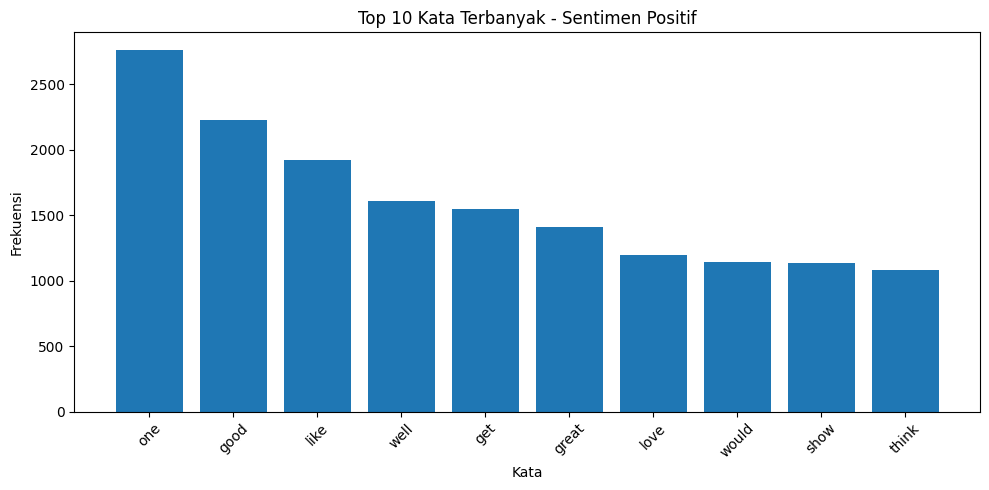

In [15]:
# Visualisasi positif
plt.figure(figsize=(10, 5))
words, counts = zip(*positive_counts)
plt.bar(words, counts)
plt.title("Top 10 Kata Terbanyak - Sentimen Positif")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

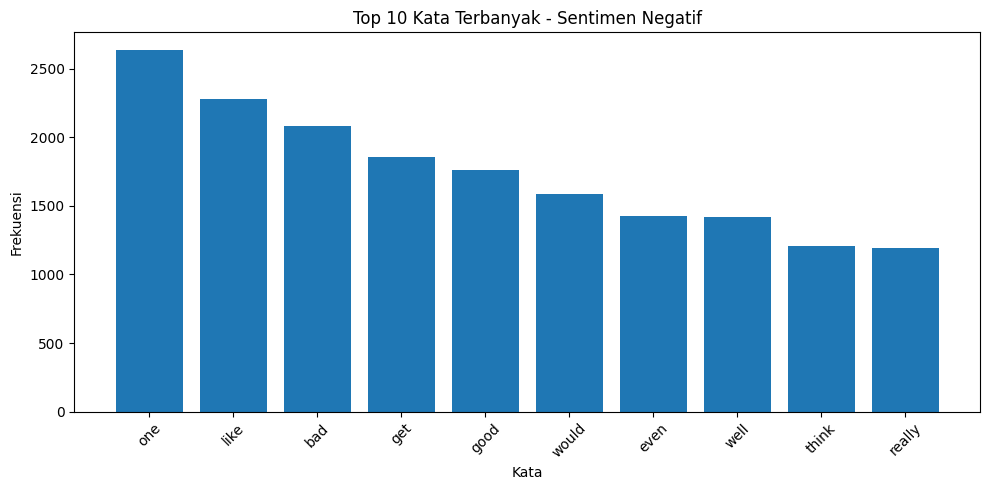

In [16]:
# Visualisasi negatif
plt.figure(figsize=(10, 5))
words, counts = zip(*negative_counts)
plt.bar(words, counts)
plt.title("Top 10 Kata Terbanyak - Sentimen Negatif")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Wordcloud

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil semua teks per sentimen
positive_text = " ".join(df_sample[df_sample['sentiment'] == 'positive']['clean_review'])
negative_text = " ".join(df_sample[df_sample['sentiment'] == 'negative']['clean_review'])

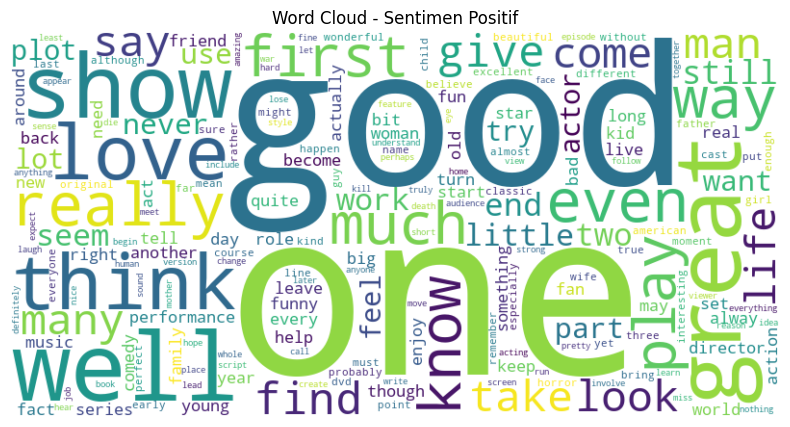

In [18]:
# WordCloud - Sentimen Positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()

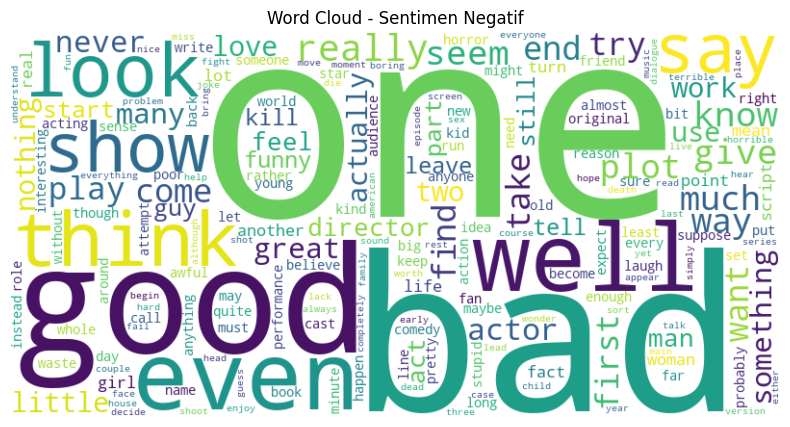

In [ ]:
# WordCloud - Sentimen Negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()

### 1.4 Dataset Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest

In [2]:
df = pd.read_csv('datasets/cleaned/IMDB_dataset_5000_cleaned.csv')
df.sample(10)

,Unnamed: 0,review,sentiment,clean_review
545,545,Feh. This movie started out in an interesting ...,negative,feh start interesting manner quickly run gamut...
1073,1073,This movie was working toward two goals: to ma...,positive,work toward two goal political point tell scar...
3608,3608,Robert Siodmak does a fabulous job with this B...,positive,robert siodmak fabulous job noir star ella rai...
413,413,The casting of Robert Culp is probably the onl...,positive,casting robert culp probably decent move produ...
3803,3803,'Anita and Me' is a drama about growing up in ...,negative,anita drama grow multiethnic britain rather li...
2843,2843,"In the winter of 1931, supposedly 12-year-old ...",positive,winter 1931 supposedly 12yearold tyler hoechli...
2456,2456,My baby sitter was a fan so I saw many of the ...,positive,baby sitter fan many old episode grow fan scoo...
3669,3669,"Poor acting, no script, no plot, no convincing...",negative,poor act script plot convincing killer suspens...
3689,3689,Although it really isn't such a terribly movie...,negative,although really terribly especially consider d...
2582,2582,I just watched the 30th Anniversary edition of...,negative,30th anniversary edition blaze saddle one favo...


#### 1.4.1 TF-IDF Vectorizing

In [4]:
X_text = df['clean_review'].astype(str)
y = df['sentiment']

In [5]:
vectorizer = TfidfVectorizer(
    max_features=10000,       # Batasi jumlah kata (fitur)
    ngram_range=(1, 2),       # Unigram dan bigram
    min_df=100,               # Kata harus muncul di ≥100 dokumen
    max_df=0.9,               # Hapus kata yang muncul di >90% dokumen
    sublinear_tf=True,        # Scaling untuk TF agar lebih stabil
    stop_words="english"      # Stop Words
)

In [6]:
vectorizer.fit(X_text)
joblib.dump(vectorizer, 'output/tfidf/IMDB_dataset_5000_tfidf_vectorizer.pkl')

['output/tfidf/IMDB_dataset_5000_tfidf_vectorizer.pkl']

In [7]:
X_tfidf = vectorizer.transform(X_text)

In [8]:
feature_names = np.array(vectorizer.get_feature_names_out())
feature_names

array(['ability', 'able', 'absolutely', 'act', 'acting', 'action',
       'actor', 'actress', 'actual', 'actually', 'add', 'admit', 'adult',
       'adventure', 'age', 'ago', 'agree', 'air', 'allow', 'amazing',
       'america', 'american', 'annoying', 'apparently', 'appeal',
       'appear', 'appearance', 'appreciate', 'art', 'ask', 'aspect',
       'atmosphere', 'attack', 'attempt', 'attention', 'audience',
       'average', 'avoid', 'award', 'away', 'awesome', 'awful',
       'background', 'bad', 'badly', 'base', 'basically', 'battle',
       'bear', 'beautiful', 'begin', 'beginning', 'believable', 'believe',
       'big', 'bit', 'bizarre', 'black', 'blood', 'blow', 'body', 'book',
       'bore', 'boring', 'bother', 'box', 'boy', 'brain', 'break',
       'brilliant', 'bring', 'british', 'brother', 'budget', 'build',
       'bunch', 'business', 'buy', 'camera', 'capture', 'car', 'care',
       'career', 'carry', 'case', 'cast', 'catch', 'cause', 'certain',
       'certainly', 'chance

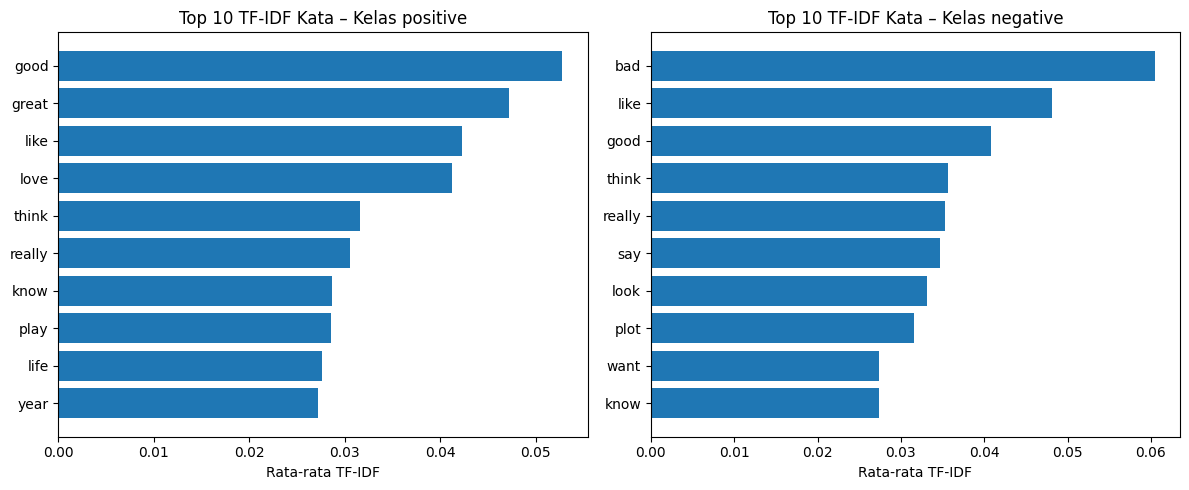

In [9]:
def plot_top_words_by_class(X, y, feature_names, kelas, top_n=10):
    X_class = X[np.array(y) == kelas]
    mean_scores = np.asarray(X_class.mean(axis=0)).flatten()
    top_idx = mean_scores.argsort()[-top_n:][::-1]
    top_words = feature_names[top_idx]
    top_scores = mean_scores[top_idx]

    plt.barh(top_words[::-1], top_scores[::-1])
    plt.title(f"Top {top_n} TF-IDF Kata – Kelas {kelas}")
    plt.xlabel("Rata-rata TF-IDF")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_top_words_by_class(X_tfidf, y, feature_names, "positive")

plt.subplot(1, 2, 2)
plot_top_words_by_class(X_tfidf, y, feature_names, "negative")
plt.tight_layout()
plt.show()

In [10]:
chi2_scores, _ = chi2(X_tfidf, y)
selector = SelectKBest(score_func=chi2, k=3000)

In [ ]:
selector.fit(X_tfidf, y)
joblib.dump(selector, 'output/tfidf/IMDB_dataset_5000_tfidf_chi2.pkl')

/home/user/moviereviewml/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=3000 is greater than n_features=686. All the features will be returned.
  warnings.warn(


['output/tfidf/IMDB_dataset_5000_tfidf_chi2.pkl']

In [12]:
X_selected = selector.transform(X_tfidf)

In [30]:
# joblib.dump(X_selected, 'output/tfidf/IMDB_dataset_5000_tfidf_chi2.pkl')
# joblib.dump(y, 'output/labels/sentiment_labels.pkl')

['output/labels/sentiment_labels.pkl']

In [13]:
mask = selector.get_support()
selected_features = feature_names[mask]
selected_features

array(['ability', 'able', 'absolutely', 'act', 'acting', 'action',
       'actor', 'actress', 'actual', 'actually', 'add', 'admit', 'adult',
       'adventure', 'age', 'ago', 'agree', 'air', 'allow', 'amazing',
       'america', 'american', 'annoying', 'apparently', 'appeal',
       'appear', 'appearance', 'appreciate', 'art', 'ask', 'aspect',
       'atmosphere', 'attack', 'attempt', 'attention', 'audience',
       'average', 'avoid', 'award', 'away', 'awesome', 'awful',
       'background', 'bad', 'badly', 'base', 'basically', 'battle',
       'bear', 'beautiful', 'begin', 'beginning', 'believable', 'believe',
       'big', 'bit', 'bizarre', 'black', 'blood', 'blow', 'body', 'book',
       'bore', 'boring', 'bother', 'box', 'boy', 'brain', 'break',
       'brilliant', 'bring', 'british', 'brother', 'budget', 'build',
       'bunch', 'business', 'buy', 'camera', 'capture', 'car', 'care',
       'career', 'carry', 'case', 'cast', 'catch', 'cause', 'certain',
       'certainly', 'chance

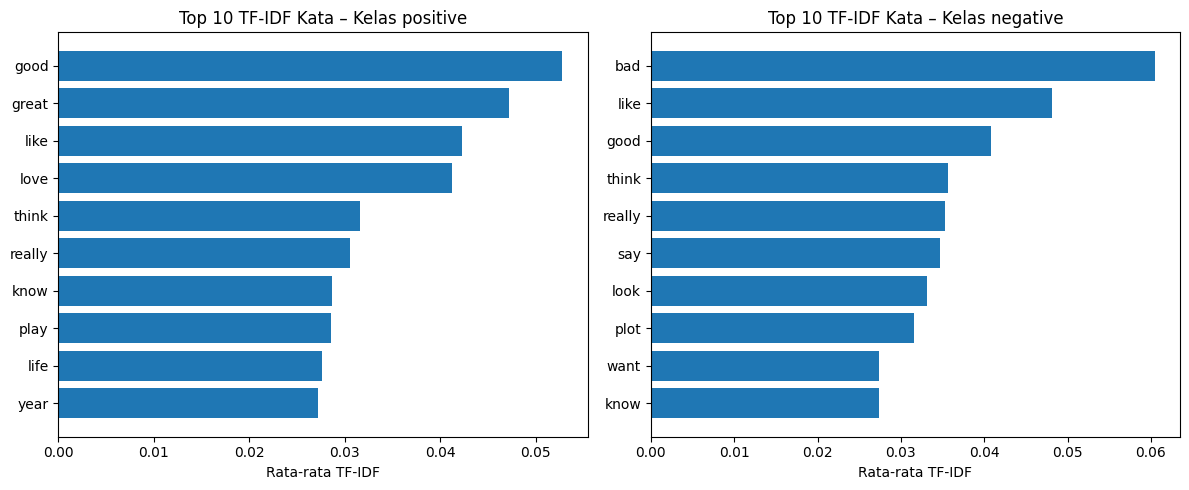

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_top_words_by_class(X_selected, y, selected_features, "positive")

plt.subplot(1, 2, 2)
plot_top_words_by_class(X_selected, y, selected_features, "negative")
plt.tight_layout()
plt.show()

#### 1.4.2 FastText Vectorizing

In [33]:
import fasttext
import pandas as pd
import numpy as np
import seaborn as sns

In [10]:
pip install numpy==1.24.4

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
train_data = 'output/fasttext/IMDB_dataset_5000_fasttext.txt'

with open(train_data, 'w') as f:
    for index, row in df_filtered.iterrows():
        label = '__label__' + row['sentiment']
        text = row['clean_review'].replace('\n', ' ')
        f.write(f'{label} {text}\n')

In [6]:
model_fasttext = fasttext.train_supervised(train_data, lr=1.0, epoch=25, wordNgrams=2)

Read 0M words
Number of words:  46757
Number of labels: 2
Progress: 100.0% words/sec/thread:  597732 lr:  0.000000 avg.loss:  0.037756 ETA:   0h 0m 0s


In [7]:
def predict_fasttext(text):
    if pd.notnull(text):
        try:
            label, _ = model_fasttext.predict(text)
            return label[0]
        except Exception as e:
            print(f"Error saat memproses teks: {text} - {e}")
    return None

In [8]:
df_filtered['fasttext_sentiment'] = df_filtered['clean_review'].apply(predict_fasttext)

In [9]:
import pandas as pd

tfidf_df = pd.read_csv('output/tfidf/IMDB_dataset_5000_tfidf.csv')
tfidf_df.drop(columns=['sentiment'])

: 

In [1]:
df_final = pd.concat([df_filtered[['clean_review', 'sentiment', 'fasttext_sentiment']], tfidf_df], axis=1)
df_final.sample(5)

NameError: name 'pd' is not defined

Bad pipe message: %s [b' 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Sa']
Bad pipe message: %s [b'ri/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/', b'ng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nA']
Bad pipe message: %s [b'ept-Language: en-US,en;q=0.9,id;q=0.8\r\nPriority: u=0, i\r\nReferer: https://idx.google.com/\r\nSec-Ch-', b': "Google Chrome";v="137", "Chromium";v="137", "Not/A)Brand";v="24"\r\nSec-Ch-Ua-Arch:', b'x86"\r\nSec-Ch-Ua-Bitness: "64"\r\n']
Bad pipe message: %s [b'c-Ch-Ua-Form-Factors: "Desktop"\r\nSec-Ch-Ua-Full-Version: "137.0.7151.104"\r\nSec-Ch-', b'-Full-Version-List: "Google Chrome";v="137.0.7151.104", "Chromium";v="137.0.7151.104', b' "Not/A)Brand";v="24.0.0.0"\r\nSec-']
Bad pipe message: %s [b'-Ua-Mobile: ?0\r\nSec-Ch-Ua-Model: ""\r\nSec-Ch-Ua-Platform: "Windows"']
Bad pipe message: %s [b'Sec-Ch-Ua-Pl']
Bad pipe message: %s 

In [19]:
df_final['fasttext_sentiment_num'] = df_final['fasttext_sentiment'].map({'__label__positive': 1, '__label__negative': 0})
df_final.sample(5)

,clean_review,sentiment,fasttext_sentiment,007,007s,010,053105,10,100,1000,...,zoney,zonke,zoo,zoom,zoweeforbidden,zshop,zucker,zulu,zuniga,fasttext_sentiment_num
446,hubert selby give book requiem dream cowrote s...,negative,__label__negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
963,jamie foxx would ever deliver wonderful oscarw...,negative,__label__negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
577,film powerful philosophical ending end mean wa...,positive,__label__positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
767,eight jean rollin film watch also possibly wei...,negative,__label__negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
970,conversation parent tell british cinema goer 1...,negative,__label__negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082166,0.0,0


In [23]:
output_file_path_with_fasttext = 'output/hybrid/IMDB_dataset_1000_tfidf_fasttext.csv'
df_final.to_csv(output_file_path_with_fasttext, index=False)

## 2. Training & Testing

### 2.1 Training

In [15]:
import pandas as pd
import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [16]:
# 1. Load cleaned data
df = pd.read_csv('datasets/cleaned/IMDB_dataset_5000_cleaned.csv')
df.sample(5)

,Unnamed: 0,review,sentiment,clean_review
3541,3541,This movie reminded me a lot of a song by the ...,negative,remind lot song dead kennedys call straight ho...
4484,4484,"It was a good story, but not very well told. I...",negative,good well tell like theme main line clear coul...
151,151,Humphrey Bogart clearly did not want to be in ...,negative,humphrey bogart clearly want force play partme...
1636,1636,I provided location services on the this film ...,positive,provide location service every sunday would sh...
1587,1587,My husband rented this from a video store thin...,negative,husband rent video store think suspense never ...


In [17]:
X_text = df['clean_review']
y = df['sentiment']

In [18]:
# 2. Load vectorizer & selector
vectorizer = joblib.load('output/tfidf/IMDB_dataset_5000_tfidf_vectorizer.pkl')
selector = joblib.load('output/tfidf/IMDB_dataset_5000_tfidf_chi2.pkl')

In [19]:
# 3. Ekstraksi fitur
X_tfidf = vectorizer.transform(df['clean_review'])        # TF-IDF transform
X_selected = selector.transform(X_tfidf)                  # Apply chi2 selector

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
model = LinearSVC()
model.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [22]:
y_pred = model.predict(X_test)

In [23]:
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

🔍 Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.79      0.81       500
    positive       0.80      0.84      0.82       500

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



In [24]:
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

📊 Confusion Matrix:
[[396 104]
 [ 79 421]]


In [25]:
print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred):.4f}")

🎯 Accuracy: 0.8170
